# Credit Score Prediction

## Setup and Data Generation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import SMOTE

import shap
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
import shap
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Ensure results are repeatable
np.random.seed(42)
tf.random.set_seed(42)

We simulate 10000 unique customers and repeat their credit data over 5 months = 50,000 total rows.

In [3]:
n_customers = 10000
n_months = 5
total_rows = n_customers * n_months  # 50,0000 rows

In [4]:
customer_ids = np.repeat(np.arange(n_customers), n_months)
ages = np.random.triangular(20, 35, 60, n_customers).astype(int)
genders = np.random.choice(['M', 'F'], size=n_customers, p=[0.6, 0.4])

In [5]:
# Define Indian cities by tiers

tier_1_cities = ['Mumbai', 'Delhi', 'Bangalore', 'Chennai', 'Hyderabad', 'Kolkata']
tier_2_cities = ['Pune', 'Ahmedabad', 'Jaipur', 'Surat', 'Lucknow', 'Kanpur', 'Nagpur', 'Indore', 'Bhopal']
tier_3_cities = ['Patna', 'Ranchi', 'Guwahati', 'Amritsar', 'Ujjain', 'Gorakhpur', 'Jamnagar', 'Guntur', 'Hubli', 'Warangal']

# Combine all cities
all_cities = tier_1_cities + tier_2_cities + tier_3_cities

# Assign approximate weights based on financial inclusion and urbanization levels
city_weights = (
    [0.06] * len(tier_1_cities) +   # 6 cities × 0.06 = 36%
    [0.035] * len(tier_2_cities) +  # 9 cities × 0.035 = 31.5%
    [0.025] * len(tier_3_cities)    # 10 cities × 0.025 = 25%
)

# Normalize weights to sum to 1 (required for np.random.choice)
city_weights = np.array(city_weights)
city_weights = city_weights / city_weights.sum()

# Assign locations to customers using weighted sampling
locations = np.random.choice(all_cities, size=n_customers, p=city_weights)


In [6]:
monthly_income = np.abs(np.random.normal(45000, 15000, total_rows))
monthly_emi = np.abs(np.random.normal(15000, 6000, total_rows))
monthly_emi = np.minimum(monthly_emi, monthly_income * 0.5)  # EMI should not exceed 50% of income

In [7]:
credit_utilization = np.clip(np.random.beta(2, 5, total_rows) * 1.5, 0, 1.5)
total_credit_limit = monthly_income * np.random.uniform(2, 5, total_rows)
current_outstanding = total_credit_limit * credit_utilization


In [8]:
num_open_loans = np.random.poisson(2, total_rows).clip(0, 8)
repayment_score = np.random.beta(8, 2, total_rows) * 100
dpd = np.random.exponential(5, total_rows).clip(0, 90)


In [9]:
hard_inquiries = np.random.poisson(0.7, total_rows).clip(0, 8)
credit_usage = np.abs(np.random.normal(20000, 8000, total_rows))
loan_disbursed = np.where(np.random.rand(total_rows) > 0.8, 
                         np.abs(np.random.normal(100000, 40000)), 0)


In [10]:
default_months = np.where(np.random.rand(total_rows) > 0.9, 
                          np.random.randint(0, 36), 120)


In [11]:
# Select 5% of unique customers (500 if n_customers = 10,000)
num_high_risk_customers = int(n_customers * 0.05)
high_risk_customer_ids = np.random.choice(np.arange(n_customers), size=num_high_risk_customers, replace=False)


In [12]:
# Create a customer-level mask for bad customers
is_high_risk = np.isin(customer_ids, high_risk_customer_ids)

In [13]:
# Monthly EMI — push EMI to be 65–80% of income for high-risk customers
monthly_emi = np.where(
    is_high_risk,
    monthly_income * np.random.uniform(0.65, 0.8, total_rows),
    np.minimum(np.abs(np.random.normal(15000, 6000, total_rows)), monthly_income * 0.5)
)

# Credit utilization — keep near-maxed for high-risk customers
credit_utilization = np.where(
    is_high_risk,
    np.random.uniform(0.9, 1.1, total_rows),  # Over-leveraged
    np.clip(np.random.beta(2, 5, total_rows) * 1.5, 0, 1.5)
)

# Repayment history — simulate poor behavior
repayment_score = np.where(
    is_high_risk,
    np.random.uniform(20, 40, total_rows),  # Poor repayment
    np.random.beta(8, 2, total_rows) * 100
)

# DPD — make sure it's high
dpd = np.where(
    is_high_risk,
    np.random.uniform(31, 90, total_rows),  # Serious delinquency
    np.random.exponential(5, total_rows).clip(0, 90)
)

# Hard inquiries — aggressive credit-seeking
hard_inquiries = np.where(
    is_high_risk,
    np.random.randint(5, 10, total_rows),  # Too many inquiries
    np.random.poisson(0.7, total_rows).clip(0, 8)
)

# Months since last default — simulate recent defaults
default_months = np.where(
    is_high_risk,
    np.random.randint(0, 6, total_rows),  # Defaulted within last 6 months
    np.where(np.random.rand(total_rows) > 0.9, np.random.randint(0, 36), 120)
)


In [14]:
risk_score = (
    0.3 * (dpd / 90) + 
    0.25 * (credit_utilization / 1.5) + 
    0.2 * (monthly_emi / monthly_income) + 
    0.15 * (1 - repayment_score / 100) + 
    0.1 * (hard_inquiries / 8)
)



In [15]:
# Adjust bins based on actual risk score distribution
target = pd.cut(
    risk_score,
    bins=[-np.inf, 0.25, 0.45, np.inf],  # Shifted bins
    labels=['increase', 'stable', 'decrease']
)



In [16]:
# Create the final DataFrame
df = pd.DataFrame({
    'customer_id': customer_ids,
    'age': np.tile(ages, n_months),
    'gender': np.tile(genders, n_months),
    'location': np.tile(locations, n_months),
    'monthly_income': monthly_income,
    'monthly_emi_outflow': monthly_emi,
    'current_outstanding': current_outstanding,
    'credit_utilization_ratio': credit_utilization,
    'num_open_loans': num_open_loans,
    'repayment_history_score': repayment_score,
    'dpd_last_3_months': dpd,
    'num_hard_inquiries_last_6m': hard_inquiries,
    'recent_credit_card_usage': credit_usage,
    'recent_loan_disbursed_amount': loan_disbursed,
    'total_credit_limit': total_credit_limit,
    'months_since_last_default': default_months,
    'target_credit_score_movement': target
})

# Save the dataset to CSV
df.to_csv("jupiter_credit_dataset.csv", index=False)

# Confirm creation
print(f"Dataset created with shape: {df.shape}")
print(f"Saved as 'jupiter_credit_dataset.csv'")


Dataset created with shape: (50000, 17)
Saved as 'jupiter_credit_dataset.csv'


## Exploratory Data Analysis

In [17]:
df = pd.read_csv(r"C:\Users\pujar_rd15uog\Predicting-Change-in-Credit-Score\notebook\jupiter_credit_dataset.csv")

In [18]:
df.shape

(50000, 17)

In [19]:
df.columns

Index(['customer_id', 'age', 'gender', 'location', 'monthly_income',
       'monthly_emi_outflow', 'current_outstanding',
       'credit_utilization_ratio', 'num_open_loans', 'repayment_history_score',
       'dpd_last_3_months', 'num_hard_inquiries_last_6m',
       'recent_credit_card_usage', 'recent_loan_disbursed_amount',
       'total_credit_limit', 'months_since_last_default',
       'target_credit_score_movement'],
      dtype='object')

In [20]:
df.head()

,customer_id,age,gender,location,monthly_income,monthly_emi_outflow,current_outstanding,credit_utilization_ratio,num_open_loans,repayment_history_score,dpd_last_3_months,num_hard_inquiries_last_6m,recent_credit_card_usage,recent_loan_disbursed_amount,total_credit_limit,months_since_last_default,target_credit_score_movement
0,0,34,M,Patna,35539.615115,16266.600385,74206.042758,0.221564,2,78.804272,18.236292,1,15003.611828,0.000000,111829.065562,17,increase
1,0,52,M,Bangalore,77104.631698,13828.797237,242610.447381,0.482510,3,74.597140,3.889527,1,19799.313909,0.000000,269221.431320,17,increase
2,0,43,M,Kolkata,69985.186208,15626.000025,156262.760078,0.354479,0,76.336869,18.432464,0,18004.715182,0.000000,174514.801674,120,increase
3,0,39,F,Indore,55964.031512,21742.257404,195244.821514,0.595708,3,80.975857,3.457098,2,26956.338441,0.000000,217598.683635,120,increase
4,0,29,M,Jaipur,39853.861039,7715.817343,44727.995697,0.330042,7,82.060687,1.782515,1,23592.385067,104685.030038,126561.646594,120,increase


In [21]:
df['target_credit_score_movement'].value_counts()

increase    40073
stable       7427
decrease     2500
Name: target_credit_score_movement, dtype: int64

In [22]:
df.tail()

,customer_id,age,gender,location,monthly_income,monthly_emi_outflow,current_outstanding,credit_utilization_ratio,num_open_loans,repayment_history_score,dpd_last_3_months,num_hard_inquiries_last_6m,recent_credit_card_usage,recent_loan_disbursed_amount,total_credit_limit,months_since_last_default,target_credit_score_movement
49995,9999,48,F,Hubli,63139.463522,21863.588188,100039.549590,0.109371,2,87.008547,4.724176,2,5701.317637,0.000000,256931.547899,120,increase
49996,9999,49,M,Patna,42011.758211,2903.900972,78781.556566,0.339990,1,89.023527,3.870433,1,14531.586549,104685.030038,178417.719527,120,increase
49997,9999,52,M,Mumbai,59778.297428,6045.272640,18488.955106,0.251453,3,92.910098,3.458567,1,14678.544756,0.000000,139253.102378,120,increase
49998,9999,35,M,Pune,51861.870715,13444.303555,22608.172785,0.215404,3,70.978273,18.381658,0,17295.711773,104685.030038,206119.441855,120,increase
49999,9999,31,M,Chennai,45967.295426,20150.485000,65749.362793,0.222998,1,65.267895,2.994572,0,21322.255134,0.000000,148344.992812,120,increase


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   50000 non-null  int64  
 1   age                           50000 non-null  int64  
 2   gender                        50000 non-null  object 
 3   location                      50000 non-null  object 
 4   monthly_income                50000 non-null  float64
 5   monthly_emi_outflow           50000 non-null  float64
 6   current_outstanding           50000 non-null  float64
 7   credit_utilization_ratio      50000 non-null  float64
 8   num_open_loans                50000 non-null  int64  
 9   repayment_history_score       50000 non-null  float64
 10  dpd_last_3_months             50000 non-null  float64
 11  num_hard_inquiries_last_6m    50000 non-null  int64  
 12  recent_credit_card_usage      50000 non-null  float64
 13  r

In [24]:
df.isnull().sum()

customer_id                     0
age                             0
gender                          0
location                        0
monthly_income                  0
monthly_emi_outflow             0
current_outstanding             0
credit_utilization_ratio        0
num_open_loans                  0
repayment_history_score         0
dpd_last_3_months               0
num_hard_inquiries_last_6m      0
recent_credit_card_usage        0
recent_loan_disbursed_amount    0
total_credit_limit              0
months_since_last_default       0
target_credit_score_movement    0
dtype: int64

In [25]:
df.describe()

,customer_id,age,monthly_income,monthly_emi_outflow,current_outstanding,credit_utilization_ratio,num_open_loans,repayment_history_score,dpd_last_3_months,num_hard_inquiries_last_6m,recent_credit_card_usage,recent_loan_disbursed_amount,total_credit_limit,months_since_last_default
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000
mean,4999.500000,37.656400,45031.112624,14712.408495,67293.357169,0.458921,2.004300,77.541905,7.715227,1.016320,20082.308724,20939.099708,157510.561316,104.50246
std,2886.780199,8.203151,14961.361189,7089.490102,49851.143883,0.264929,1.410802,16.137244,13.478446,1.640837,7919.178710,41876.000971,66442.885037,37.96318
min,0.000000,20.000000,39.701729,0.168584,35.482895,0.002280,0.000000,17.040964,0.000038,0.000000,3.927205,0.000000,95.939659,0.00000
25%,2499.750000,32.000000,34839.307643,10352.727836,30800.468450,0.251462,1.000000,70.791898,1.519204,0.000000,14648.740259,0.000000,108924.566573,120.00000
50%,4999.500000,37.000000,45093.732220,14186.862373,55351.379796,0.414711,2.000000,81.351674,3.697352,1.000000,20049.231757,0.000000,149954.623858,120.00000
75%,7499.250000,43.000000,55172.602414,18081.255342,91005.178206,0.626007,3.000000,89.045358,7.711501,1.000000,25432.830733,0.000000,199308.754781,120.00000
max,9999.000000,59.000000,101402.328729,68287.142371,478014.062573,1.372031,8.000000,99.880279,89.953436,9.000000,50926.350249,104685.030038,483378.007937,120.00000


Text(0, 0.5, 'Count')

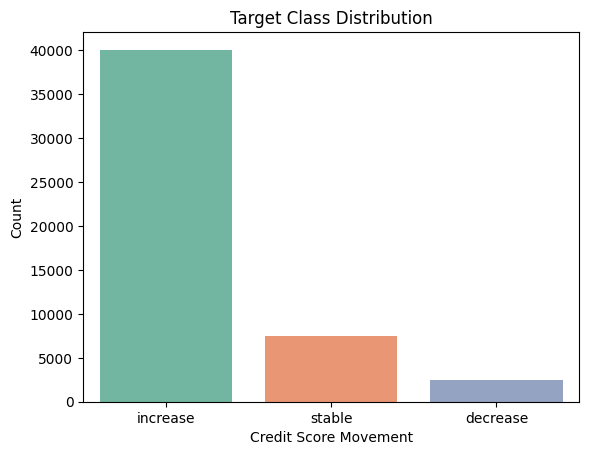

In [26]:
sns.countplot(data=df, x='target_credit_score_movement', palette='Set2')
plt.title("Target Class Distribution")
plt.xlabel("Credit Score Movement")
plt.ylabel("Count")

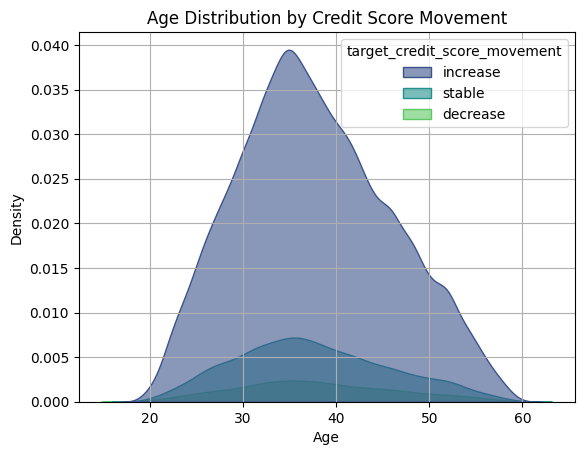

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [27]:
sns.kdeplot(data=df, x='age', hue='target_credit_score_movement', fill=True, palette='viridis', alpha=0.6)
plt.title("Age Distribution by Credit Score Movement")
plt.xlabel("Age")
plt.ylabel("Density")
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 5))

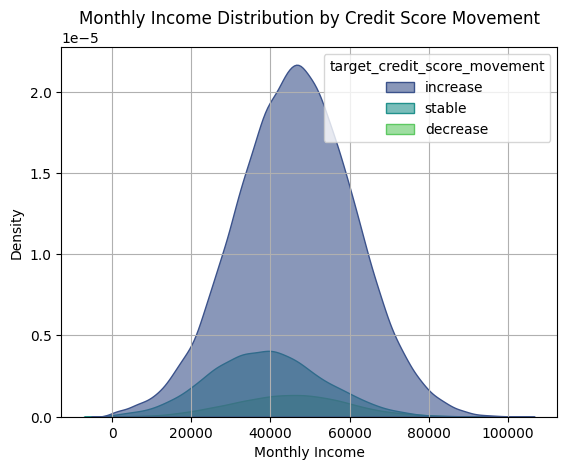

In [28]:
sns.kdeplot(data=df, x='monthly_income', hue='target_credit_score_movement', fill=True, palette='viridis', alpha=0.6)
plt.title("Monthly Income Distribution by Credit Score Movement")
plt.xlabel("Monthly Income")
plt.ylabel("Density")
plt.grid(True)
plt.show()

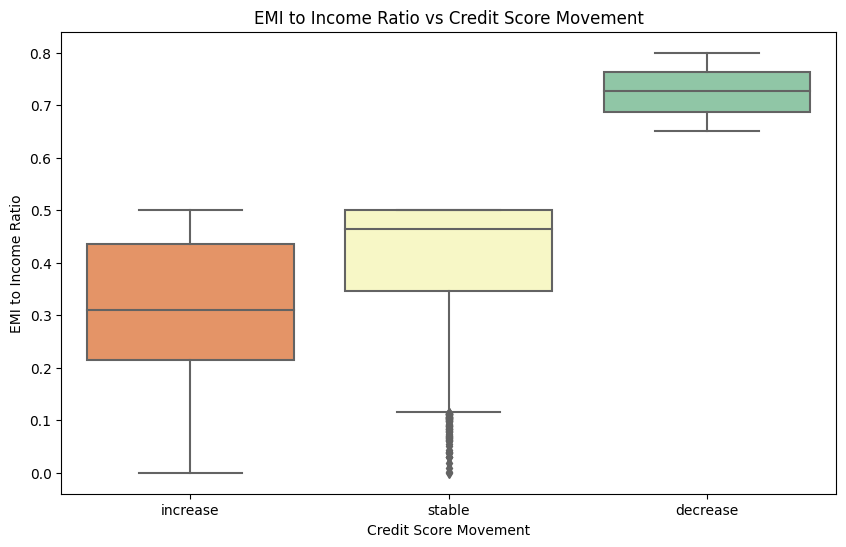

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [29]:
df['emi_income_ratio'] = df['monthly_emi_outflow'] / df['monthly_income']

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='target_credit_score_movement', y='emi_income_ratio', palette='Spectral')
plt.title("EMI to Income Ratio vs Credit Score Movement")
plt.xlabel("Credit Score Movement")
plt.ylabel("EMI to Income Ratio")
plt.show()
plt.figure(figsize=(10, 6))

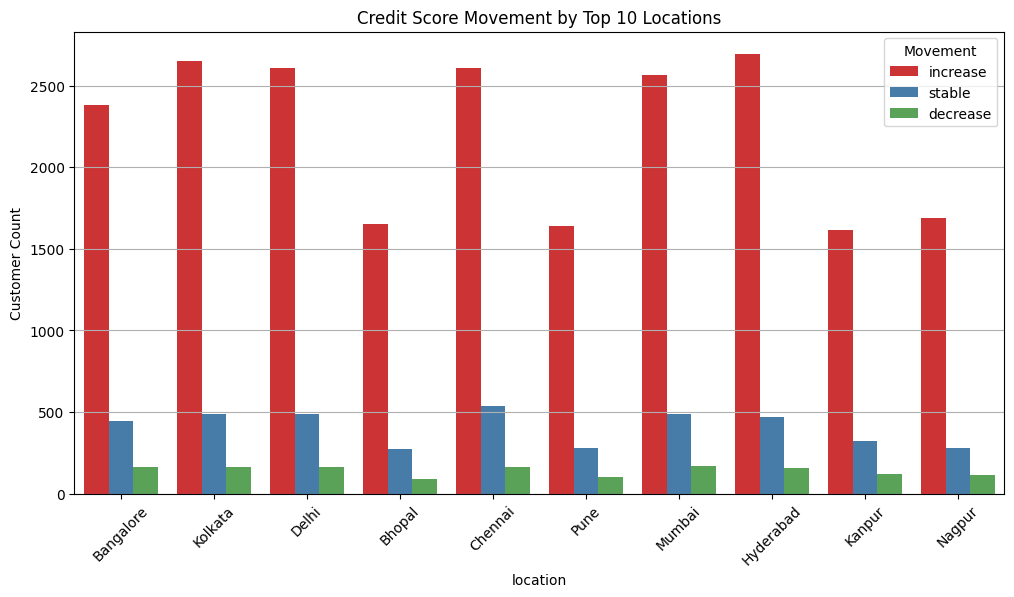

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [30]:
top_cities = df['location'].value_counts().nlargest(10).index
plt.figure(figsize=(12, 6))
sns.countplot(data=df[df['location'].isin(top_cities)], 
              x='location', hue='target_credit_score_movement', palette='Set1')
plt.title("Credit Score Movement by Top 10 Locations")
plt.xticks(rotation=45)
plt.ylabel("Customer Count")
plt.grid(True, axis='y')
plt.legend(title='Movement')
plt.show()
plt.figure(figsize=(10, 6))

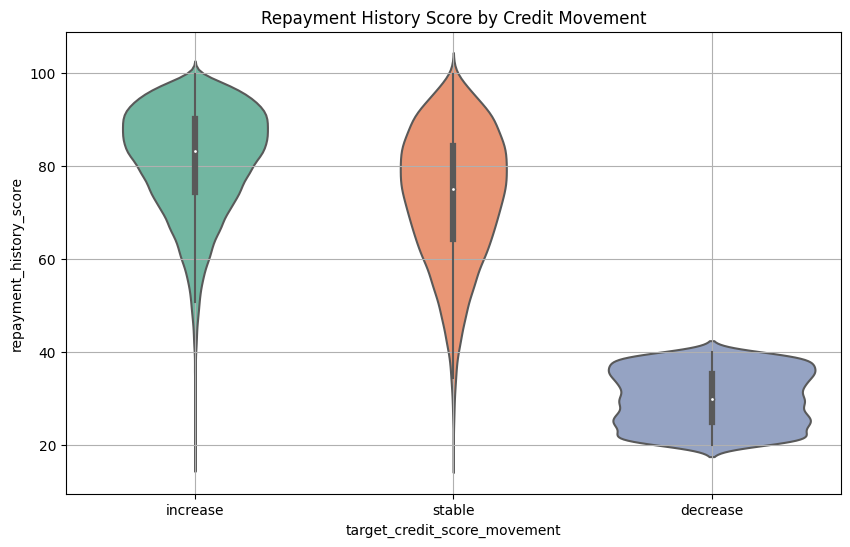

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [31]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='target_credit_score_movement', y='repayment_history_score', palette='Set2')
plt.title("Repayment History Score by Credit Movement")
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))

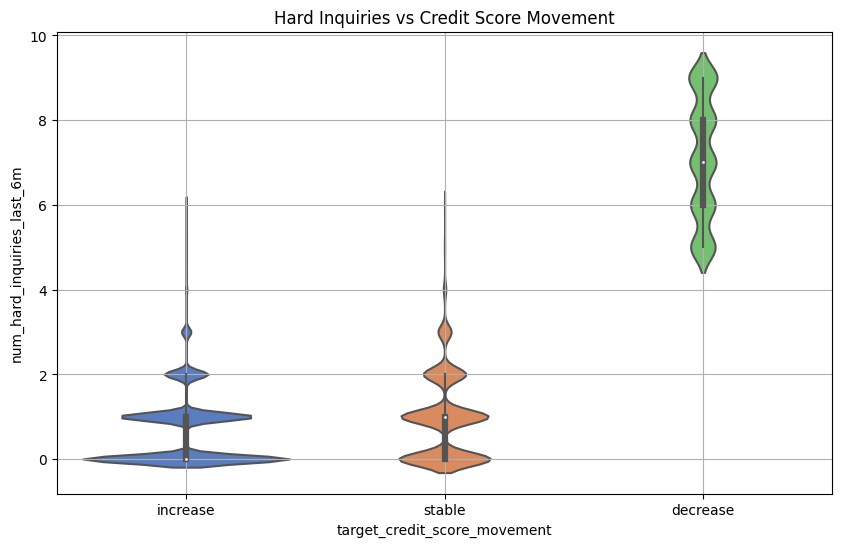

In [32]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='target_credit_score_movement', y='num_hard_inquiries_last_6m', palette='muted')
plt.title("Hard Inquiries vs Credit Score Movement")
plt.grid(True)
plt.show()

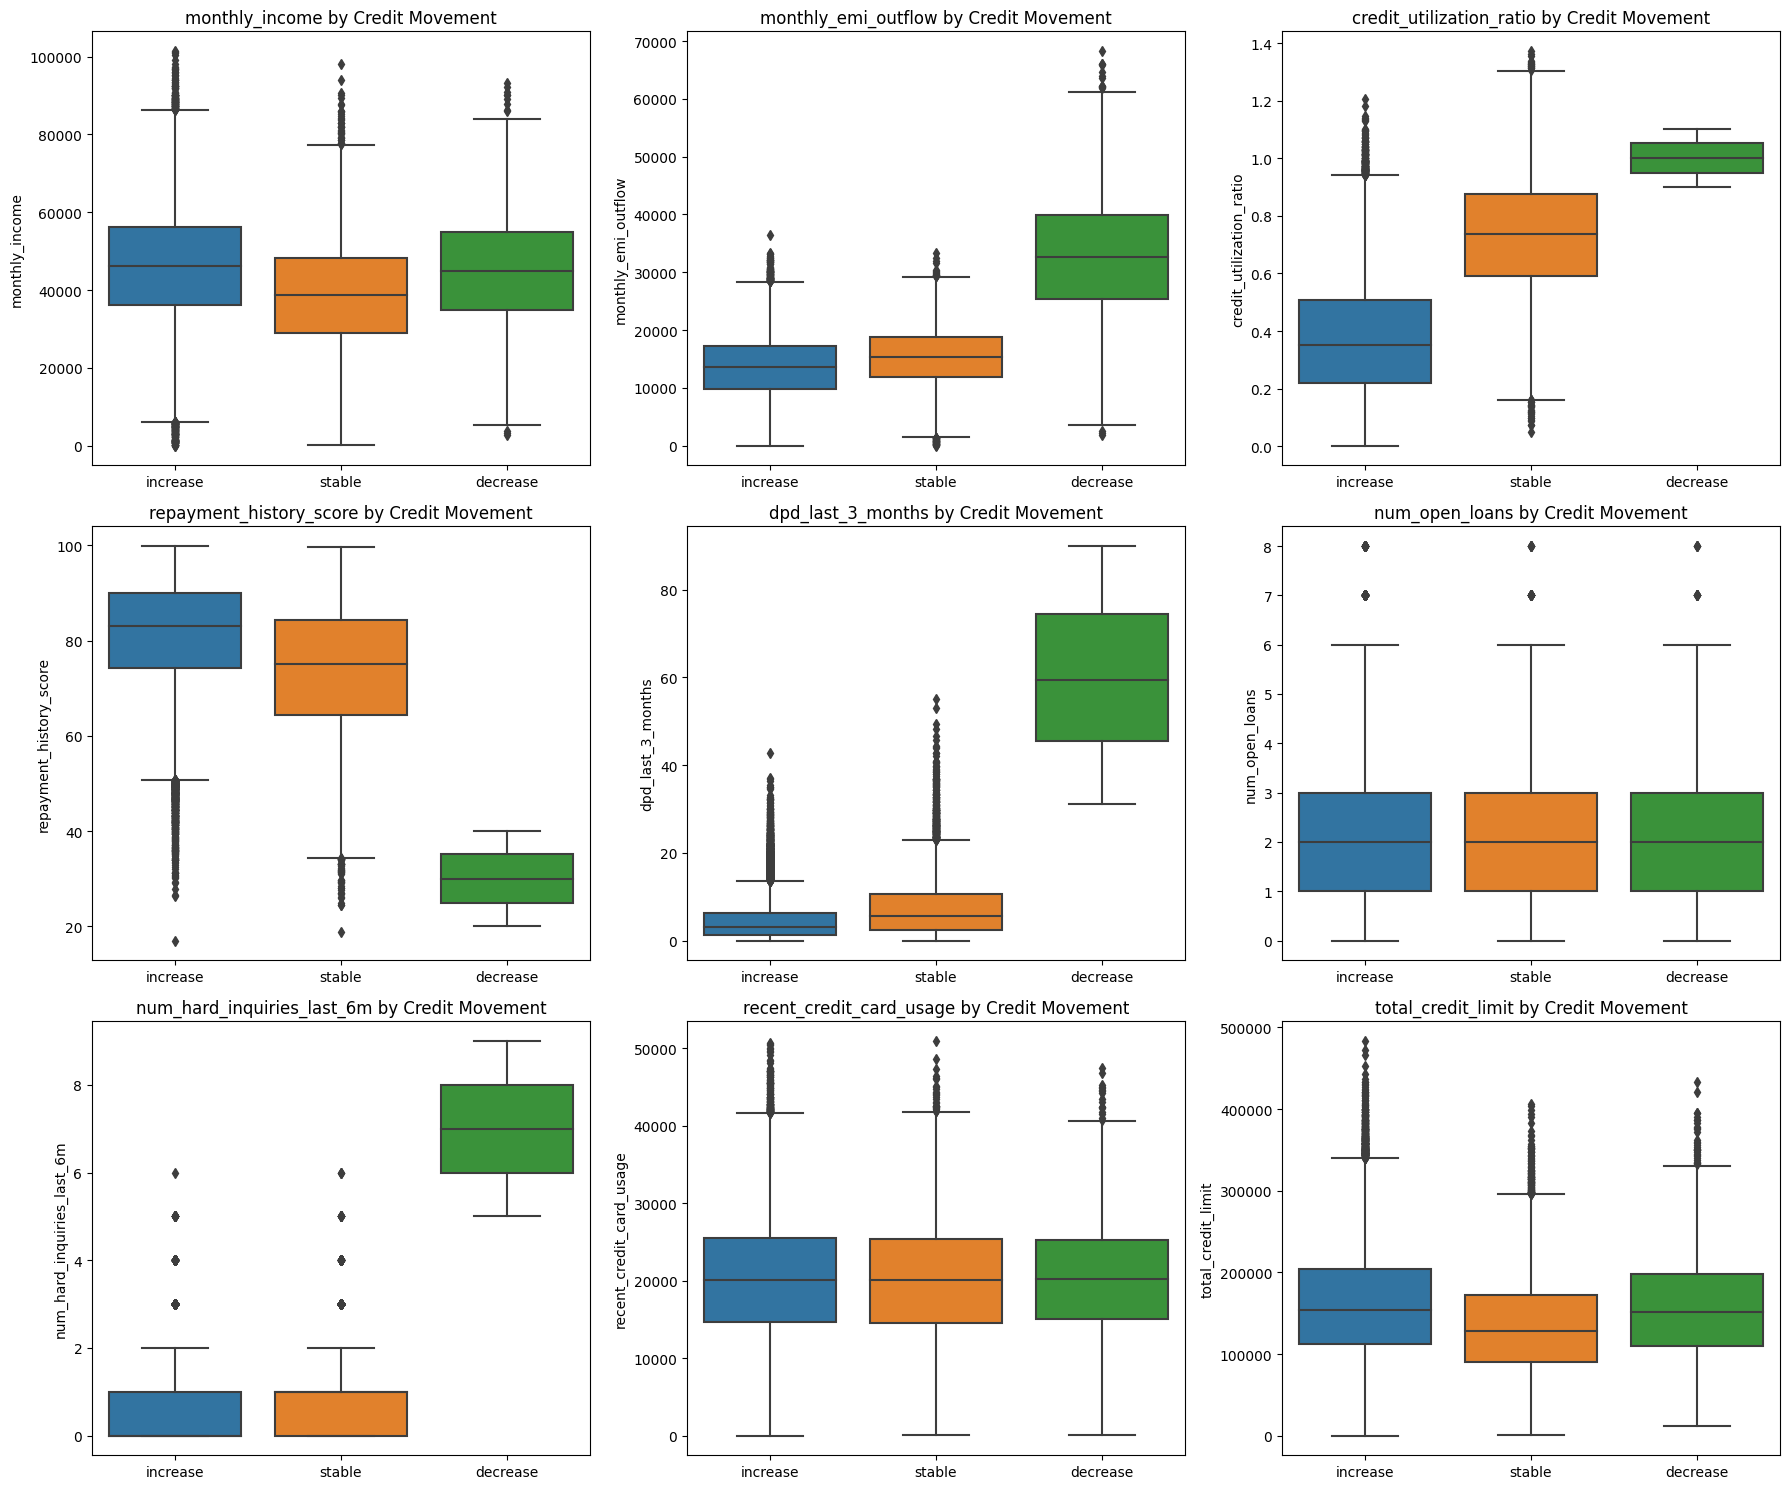

In [33]:
numerical_cols = [
    'monthly_income', 'monthly_emi_outflow', 'credit_utilization_ratio',
    'repayment_history_score', 'dpd_last_3_months', 'num_open_loans',
    'num_hard_inquiries_last_6m', 'recent_credit_card_usage',
    'total_credit_limit'
]

import math
n_cols = 3
n_rows = math.ceil(len(numerical_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5))
axes = axes.flatten()

for idx, col in enumerate(numerical_cols):
    sns.boxplot(data=df, x='target_credit_score_movement', y=col, ax=axes[idx])
    axes[idx].set_title(f"{col} by Credit Movement")
    axes[idx].set_xlabel("")
    axes[idx].set_ylabel(col)

# Hide unused subplots
for i in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


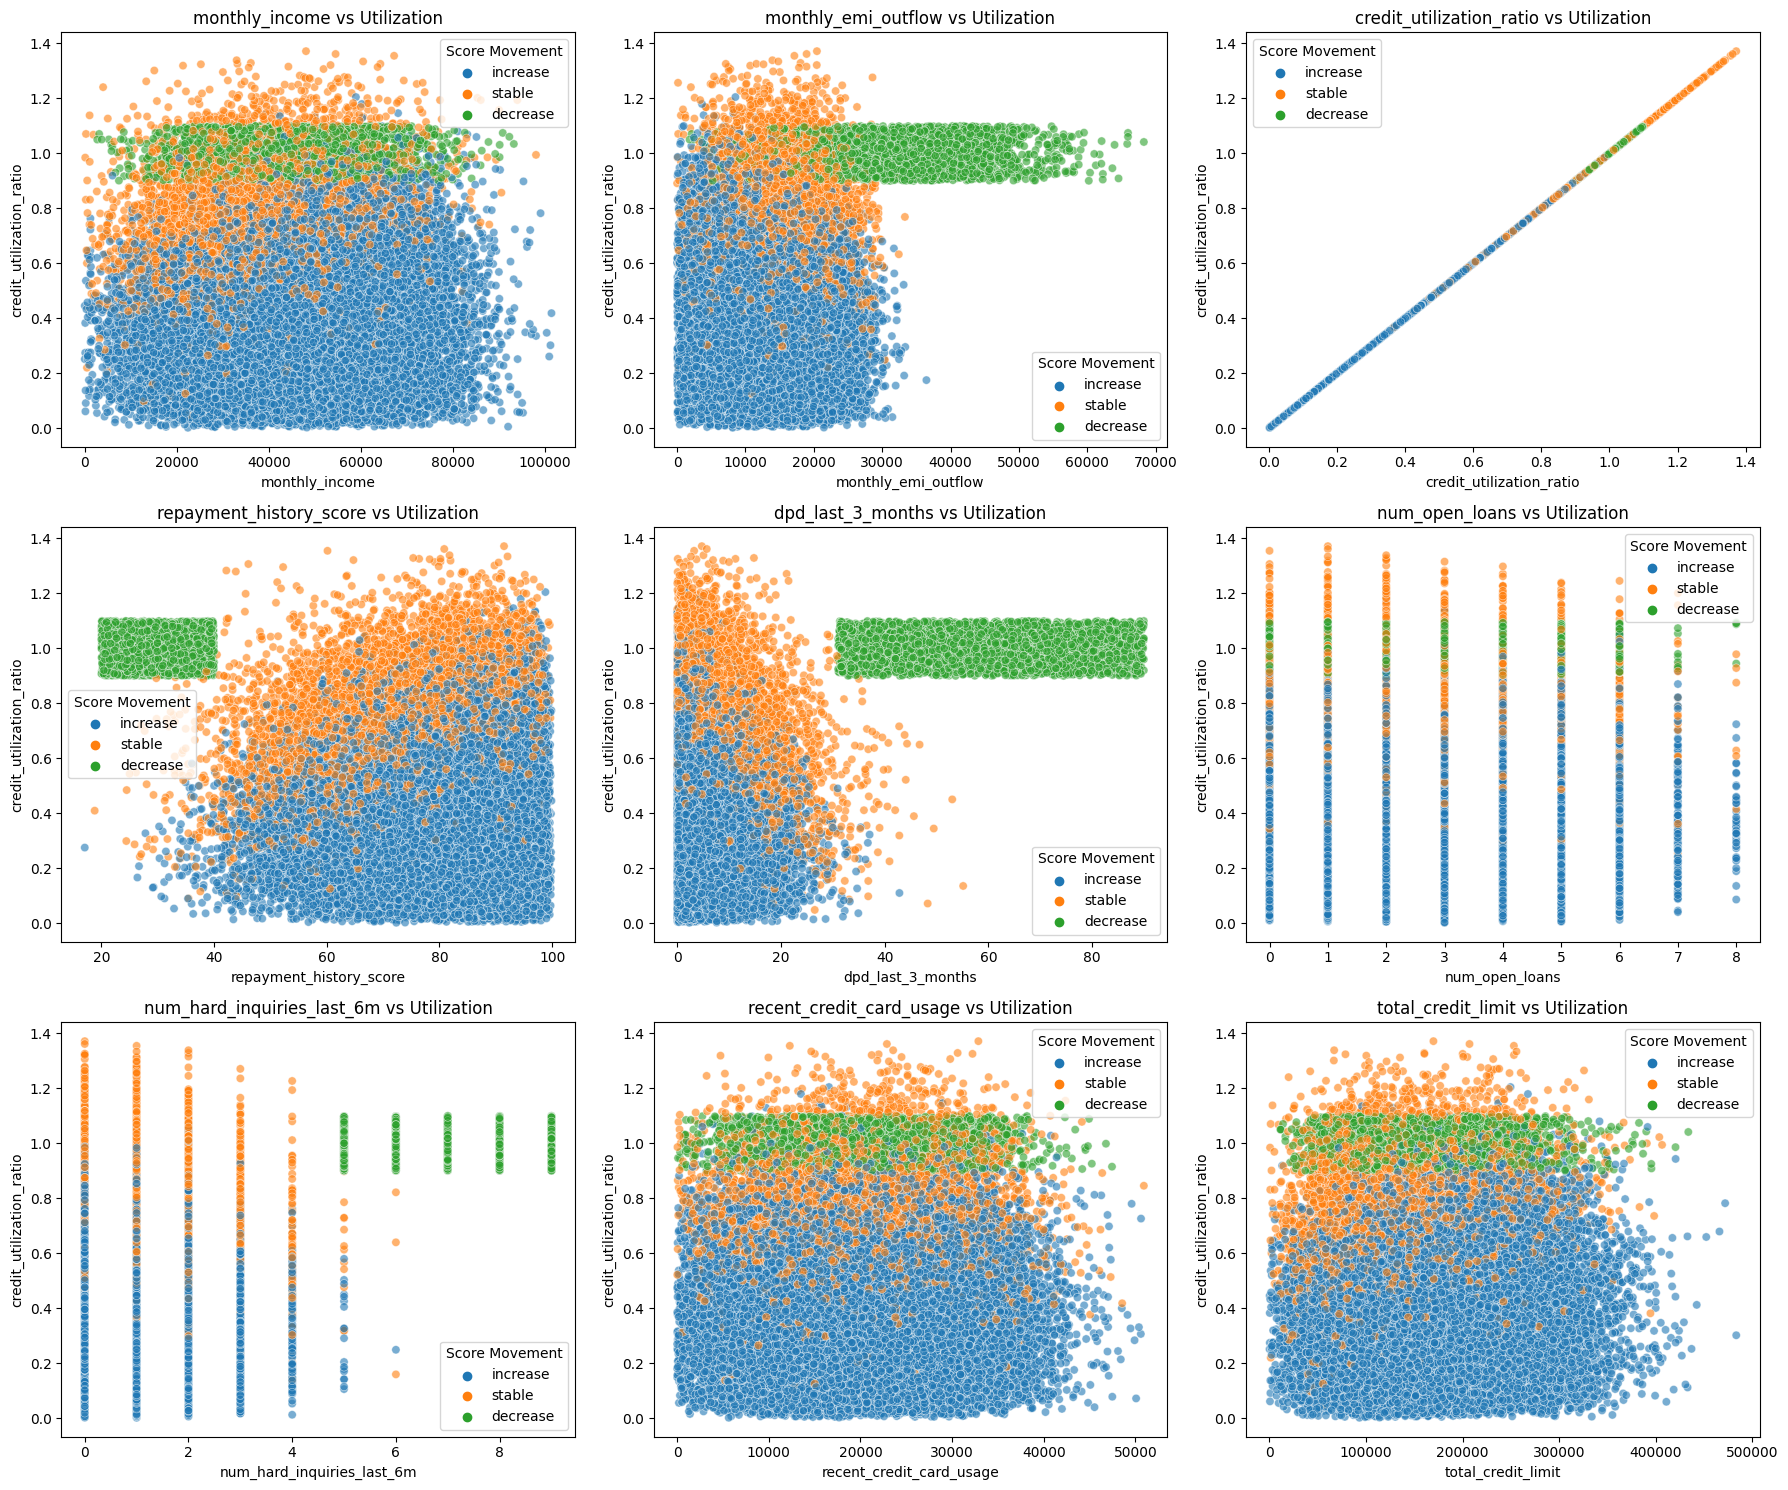

In [34]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5))
axes = axes.flatten()

for idx, col in enumerate(numerical_cols):
    sns.scatterplot(data=df, x=col, y='credit_utilization_ratio', hue='target_credit_score_movement', alpha=0.6, ax=axes[idx])
    axes[idx].set_title(f"{col} vs Utilization")
    axes[idx].legend().set_title("Score Movement")

# Hide unused subplots
for i in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


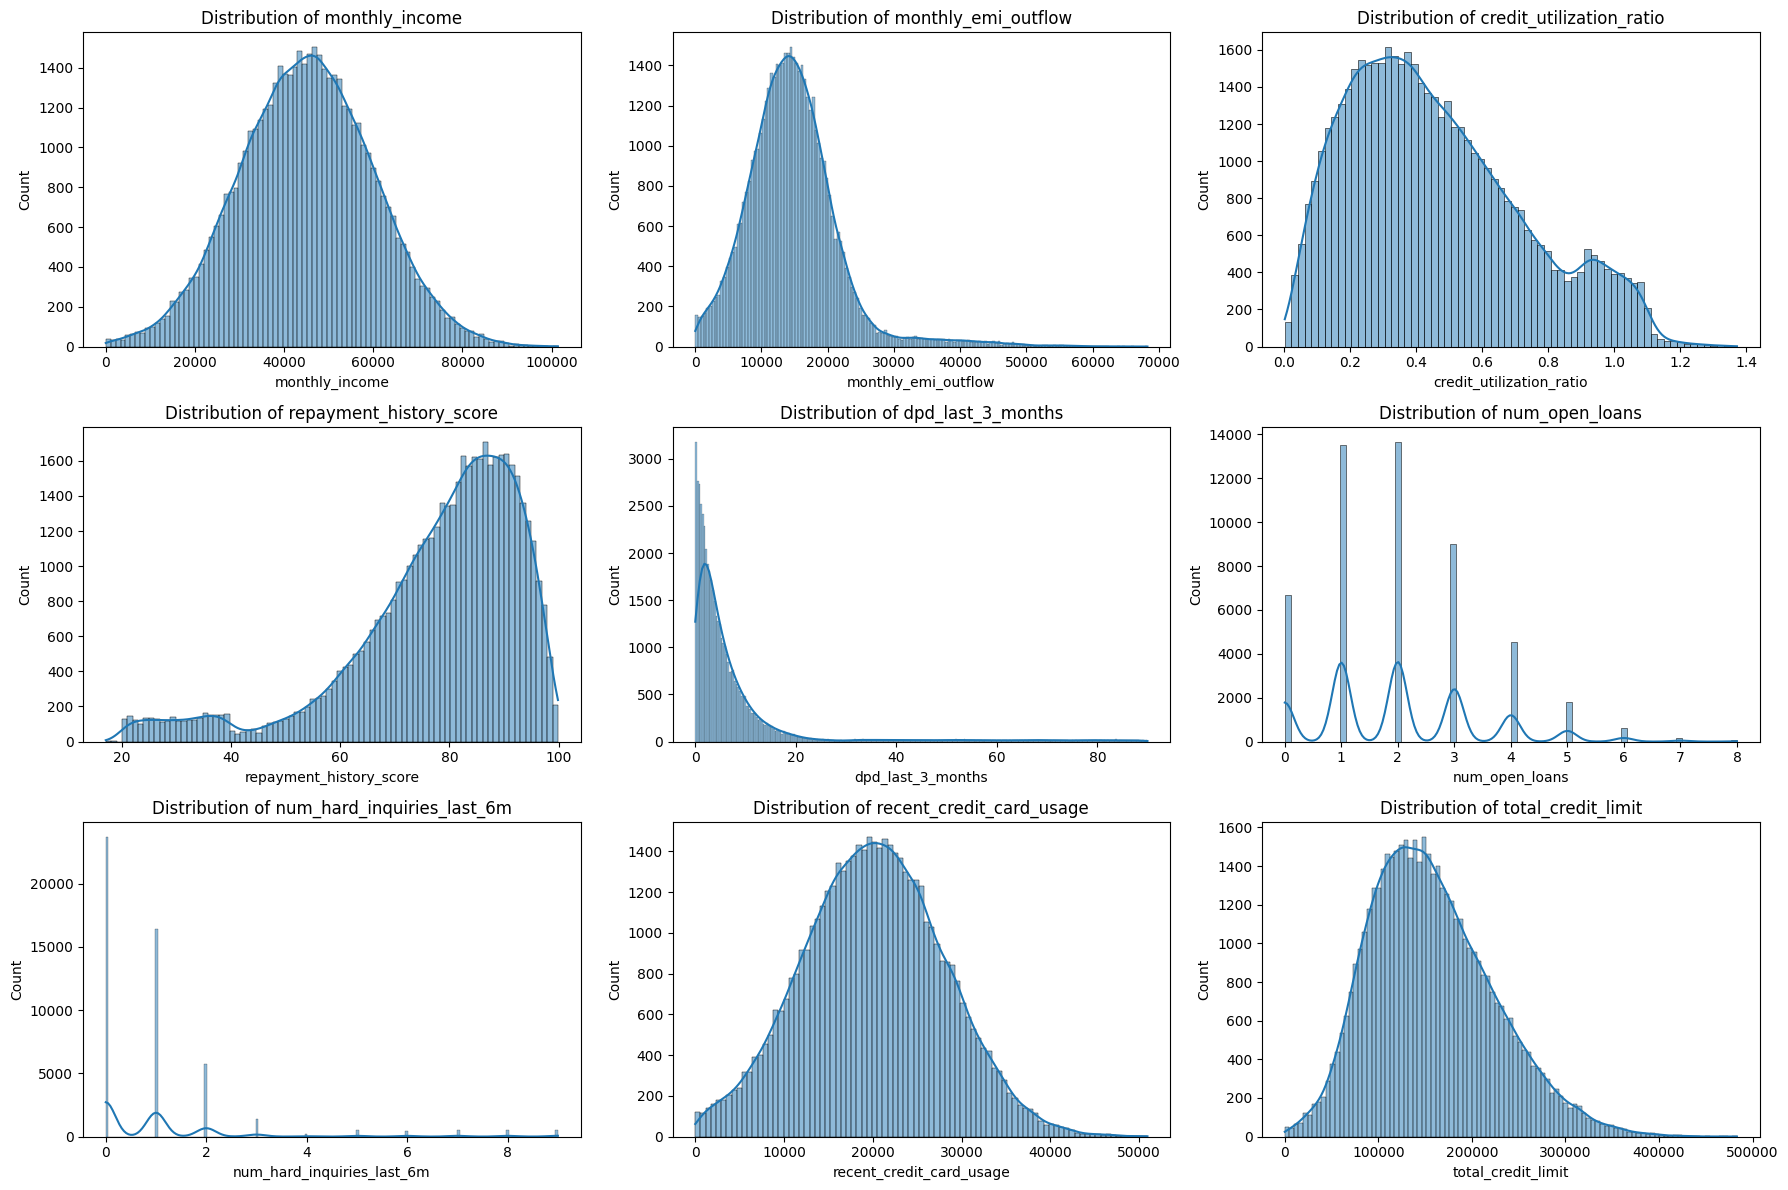

In [35]:
import math

# Set up grid size (3x3 for 9 numerical columns)
n_cols = 3
n_rows = math.ceil(len(numerical_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4))
axes = axes.flatten()

for idx, col in enumerate(numerical_cols):
    sns.histplot(data=df, x=col, kde=True, ax=axes[idx])
    axes[idx].set_title(f"Distribution of {col}")
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel("Count")

# Hide any unused subplots
for i in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

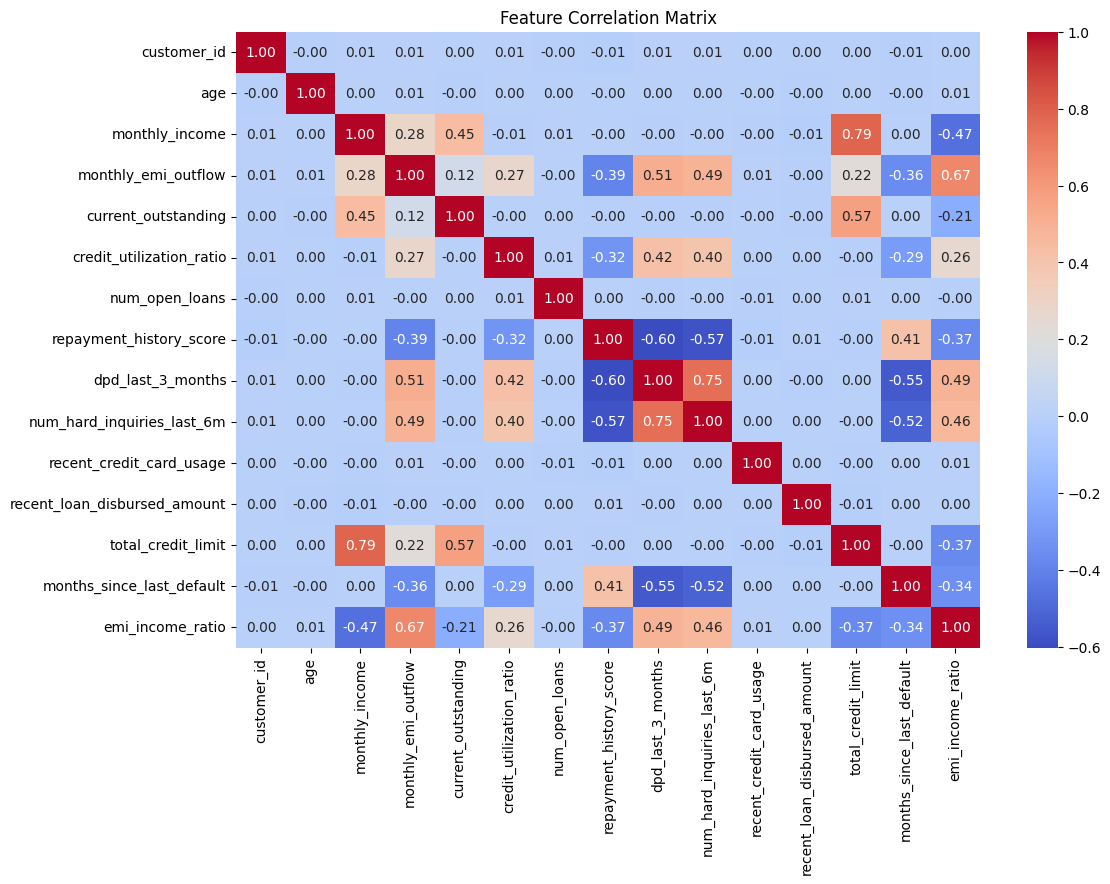

In [36]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()


## Modeling

In [37]:
# Create additional features
df['emi_income_ratio'] = df['monthly_emi_outflow'] / df['monthly_income']
df['outstanding_income_ratio'] = df['current_outstanding'] / df['monthly_income']
df['credit_utilization_binned'] = pd.cut(df['credit_utilization_ratio'], 
                                         bins=[-np.inf, 0.3, 0.7, np.inf], 
                                         labels=['Low', 'Medium', 'High'])

In [38]:
# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

In [39]:
# Remove target and ID columns
numerical_cols = [col for col in numerical_cols if col not in ['customer_id']]
categorical_cols = [col for col in categorical_cols if col not in ['target_credit_score_movement']]

print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")
print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")


Numerical columns (15): ['age', 'monthly_income', 'monthly_emi_outflow', 'current_outstanding', 'credit_utilization_ratio', 'num_open_loans', 'repayment_history_score', 'dpd_last_3_months', 'num_hard_inquiries_last_6m', 'recent_credit_card_usage', 'recent_loan_disbursed_amount', 'total_credit_limit', 'months_since_last_default', 'emi_income_ratio', 'outstanding_income_ratio']
Categorical columns (3): ['gender', 'location', 'credit_utilization_binned']


In [40]:
# Prevent data leakage by separating customers for train/test split
unique_customers = df['customer_id'].unique()
train_customers, test_customers = train_test_split(
    unique_customers, test_size=0.2, random_state=42
)

In [41]:
# Split data based on customers (prevents leakage across months)
train_df = df[df['customer_id'].isin(train_customers)].copy()
test_df = df[df['customer_id'].isin(test_customers)].copy()

print(f"Training set: {len(train_df):,} rows ({len(train_customers):,} customers)")
print(f"Test set: {len(test_df):,} rows ({len(test_customers):,} customers)")

Training set: 40,000 rows (8,000 customers)
Test set: 10,000 rows (2,000 customers)


In [42]:
X_train = train_df.drop(columns=['customer_id', 'target_credit_score_movement'])
X_test = test_df.drop(columns=['customer_id', 'target_credit_score_movement'])
y_train = train_df['target_credit_score_movement']
y_test = test_df['target_credit_score_movement']

In [43]:
# Encode target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print("Data split completed without leakage")

Data split completed without leakage


In [44]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ]
)


In [45]:
# Fit preprocessing on training data only
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Processed training data shape: {X_train_processed.shape}")
print(f"Processed test data shape: {X_test_processed.shape}")


Processed training data shape: (40000, 45)
Processed test data shape: (10000, 45)


In [46]:
# Apply SMOTE only to training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train_encoded)

print("Class distribution after SMOTE:")
unique, counts = np.unique(y_train_balanced, return_counts=True)
for i, (cls, count) in enumerate(zip(unique, counts)):
    print(f"Class {cls} ({label_encoder.classes_[cls]}): {count:,}")


Class distribution after SMOTE:
Class 0 (decrease): 32,116
Class 1 (increase): 32,116
Class 2 (stable): 32,116


In [47]:
# Define models with regularization to prevent overfitting
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=10,
        class_weight='balanced',
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=42,
        eval_metric='mlogloss'
    ),
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        multi_class='multinomial',
        C=1.0,
        random_state=42
    ),
    
}

In [48]:
# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model_results = {}

print("Training models with cross-validation...")
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Cross-validation on training data
    cv_scores = cross_val_score(model, X_train_balanced, y_train_balanced, 
                               cv=cv, scoring='f1_macro')
    
    # Train on full training set
    model.fit(X_train_balanced, y_train_balanced)
    
    # Predict on test set
    y_pred = model.predict(X_test_processed)
    y_pred_proba = model.predict_proba(X_test_processed)
    
    # Calculate metrics
    f1_macro = f1_score(y_test_encoded, y_pred, average='macro')
    
    model_results[name] = {
        'model': model,
        'cv_scores': cv_scores,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'test_f1_macro': f1_macro,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"CV F1 Macro: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"Test F1 Macro: {f1_macro:.4f}")

Training models with cross-validation...

Training Random Forest...
CV F1 Macro: 0.9642 (+/- 0.0029)
Test F1 Macro: 0.9094

Training XGBoost...
CV F1 Macro: 0.9929 (+/- 0.0017)
Test F1 Macro: 0.9769

Training Logistic Regression...
CV F1 Macro: 0.9975 (+/- 0.0013)
Test F1 Macro: 0.9927


Model Comparison Results:
                 Model  CV_F1_Mean  CV_F1_Std  Test_F1_Macro
2  Logistic Regression    0.997478   0.000650       0.992735
1              XGBoost    0.992869   0.000866       0.976916
0        Random Forest    0.964171   0.001453       0.909388


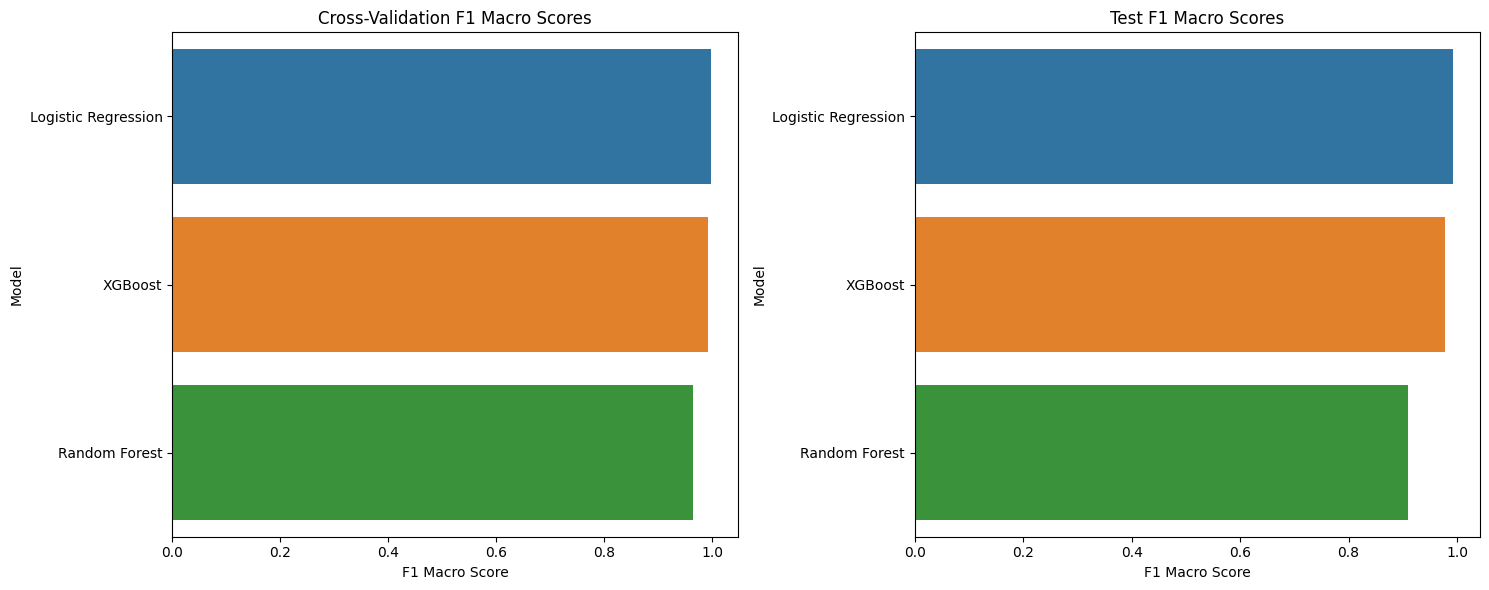

In [49]:
# Create results dataframe
results_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'CV_F1_Mean': [model_results[m]['cv_mean'] for m in model_results],
    'CV_F1_Std': [model_results[m]['cv_std'] for m in model_results],
    'Test_F1_Macro': [model_results[m]['test_f1_macro'] for m in model_results]
}).sort_values('Test_F1_Macro', ascending=False)

print("Model Comparison Results:")
print(results_df)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# CV scores comparison
sns.barplot(data=results_df, x='CV_F1_Mean', y='Model', ax=ax1)
ax1.set_title('Cross-Validation F1 Macro Scores')
ax1.set_xlabel('F1 Macro Score')

# Test scores comparison
sns.barplot(data=results_df, x='Test_F1_Macro', y='Model', ax=ax2)
ax2.set_title('Test F1 Macro Scores')
ax2.set_xlabel('F1 Macro Score')

plt.tight_layout()
plt.show()


In [50]:
results_df

,Model,CV_F1_Mean,CV_F1_Std,Test_F1_Macro
2,Logistic Regression,0.997478,0.000650,0.992735
1,XGBoost,0.992869,0.000866,0.976916
0,Random Forest,0.964171,0.001453,0.909388


Best Model: Logistic Regression
Test F1 Macro: 0.9927

Classification Report:
              precision    recall  f1-score   support

    decrease       1.00      1.00      1.00       570
    increase       1.00      0.99      1.00      7957
      stable       0.96      1.00      0.98      1473

    accuracy                           0.99     10000
   macro avg       0.99      1.00      0.99     10000
weighted avg       0.99      0.99      0.99     10000



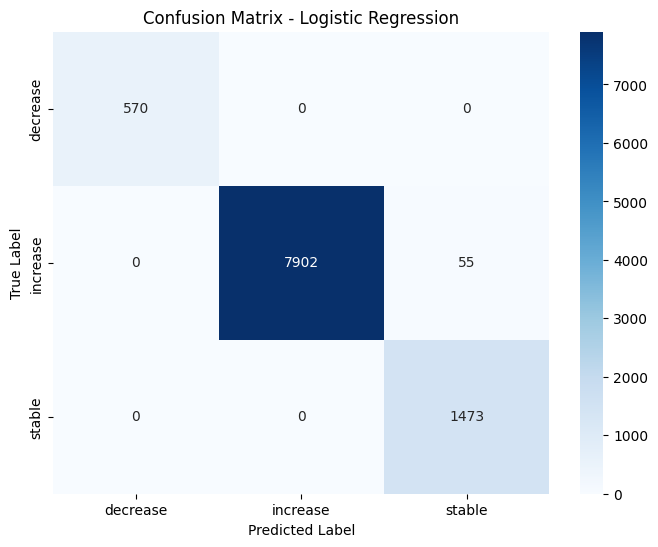

In [51]:
best_model_name = results_df.iloc[0]['Model']
best_model = model_results[best_model_name]['model']
best_predictions = model_results[best_model_name]['predictions']

print(f"Best Model: {best_model_name}")
print(f"Test F1 Macro: {model_results[best_model_name]['test_f1_macro']:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_encoded, best_predictions, 
                          target_names=label_encoder.classes_))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_encoded, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [52]:
# Prepare data for neural network
y_train_cat = to_categorical(y_train_balanced, num_classes=3)
y_test_cat = to_categorical(y_test_encoded, num_classes=3)

# Define neural network with regularization
def create_nn_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(32, activation='relu'),
        Dropout(0.1),
        
        Dense(3, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create and train neural network
nn_model = create_nn_model(X_train_balanced.shape[1])

# Callbacks for regularization
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.001
)

print("Training Neural Network...")
history = nn_model.fit(
    X_train_balanced, y_train_cat,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Training Neural Network...
Epoch 1/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9168 - loss: 0.1948 - val_accuracy: 0.9651 - val_loss: 0.1133 - learning_rate: 0.0010
Epoch 2/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9803 - loss: 0.0490 - val_accuracy: 0.9849 - val_loss: 0.0561 - learning_rate: 0.0010
Epoch 3/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9875 - loss: 0.0321 - val_accuracy: 0.9894 - val_loss: 0.0411 - learning_rate: 0.0010
Epoch 4/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9898 - loss: 0.0260 - val_accuracy: 0.9954 - val_loss: 0.0261 - learning_rate: 0.0010
Epoch 5/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9911 - loss: 0.0227 - val_accuracy: 0.9941 - val_loss: 0.0232 - learning_rate: 0.0010
Epoch 6/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9921 - loss: 0.0203 - val_accuracy: 0.9937 - val_loss: 0.0219 - learning_rate: 0.0010
Epoch 7/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 

In [53]:
# Evaluate neural network
nn_loss, nn_acc = nn_model.evaluate(X_test_processed, y_test_cat, verbose=0)
y_pred_nn = nn_model.predict(X_test_processed)
y_pred_nn_labels = np.argmax(y_pred_nn, axis=1)
nn_f1 = f1_score(y_test_encoded, y_pred_nn_labels, average='macro')

print(f"Neural Network - Test Accuracy: {nn_acc:.4f}, F1 Macro: {nn_f1:.4f}")

# Cell 19: Feature Importance Analysis
# Get feature names
feature_names = preprocessor.get_feature_names_out()

# Feature importance for tree-based models
if best_model_name in ['Random Forest', 'XGBoost']:
    feature_importance = best_model.feature_importances_
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False).head(15)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(data=importance_df, x='importance', y='feature')
    plt.title(f'Top 15 Feature Importances - {best_model_name}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Neural Network - Test Accuracy: 0.9940, F1 Macro: 0.9920


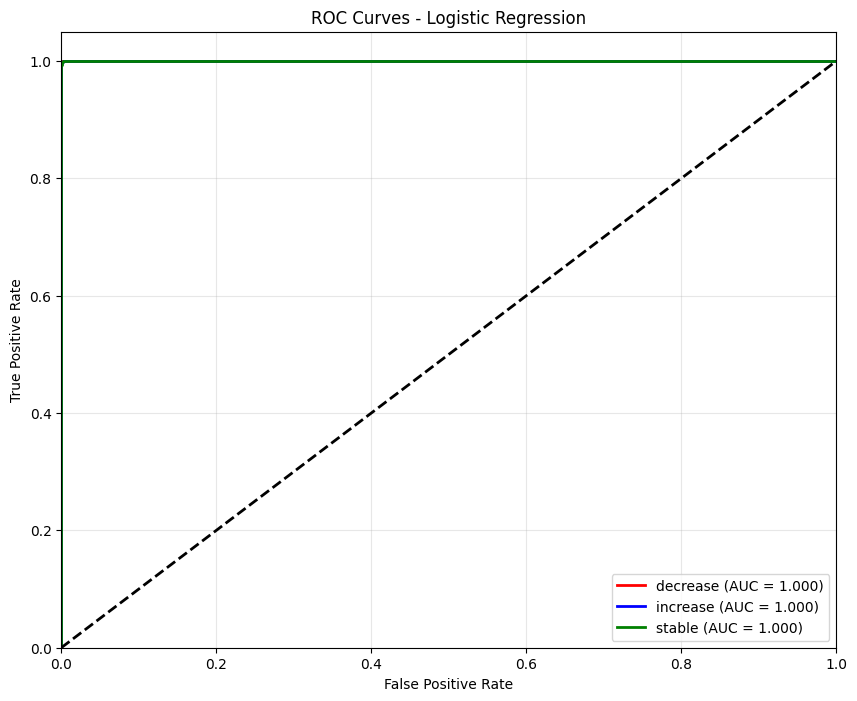

In [54]:
# Multi-class ROC curves
y_test_bin = label_binarize(y_test_encoded, classes=[0, 1, 2])
y_score = model_results[best_model_name]['probabilities']

plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green']
for i, color in enumerate(colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, linewidth=2,
             label=f'{label_encoder.classes_[i]} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves - {best_model_name}')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

 Generating SHAP explanations...
Best Model: Logistic Regression
KernelExplainer used for Logistic Regression (slower)


  0%|          | 0/50 [00:00<?, ?it/s]

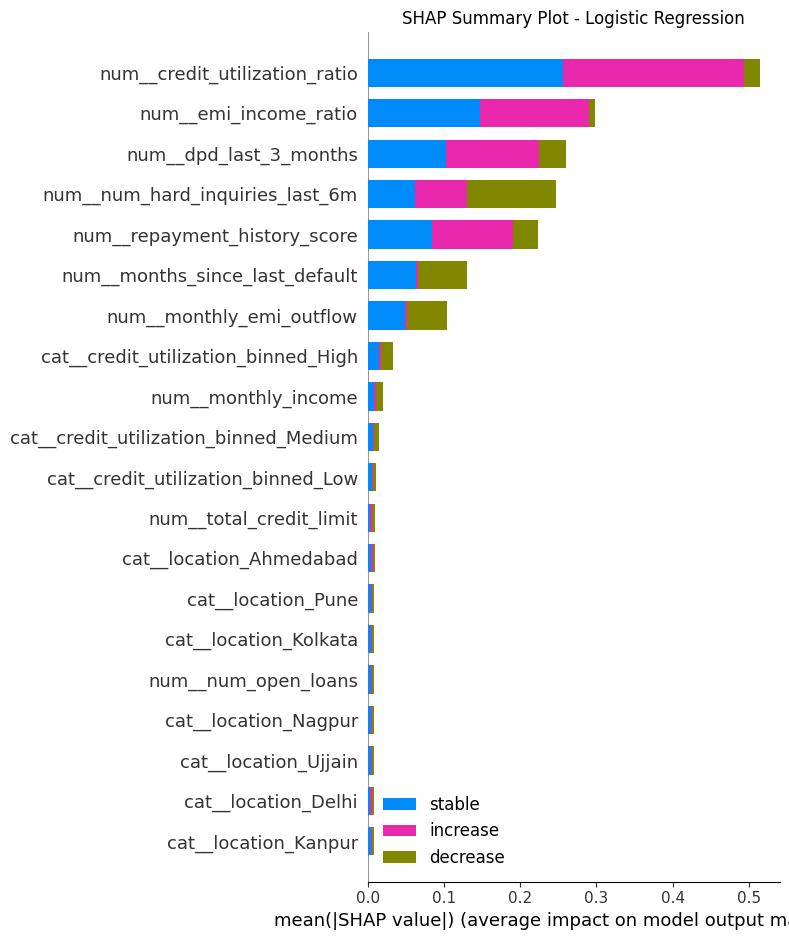

SHAP Analysis Completed


In [60]:
# SHAP Explainability + Overfitting Check
print(" Generating SHAP explanations...")

# Get best model
best_model_name = results_df.iloc[0]["Model"]
best_model = model_results[best_model_name]["model"]
print(f"Best Model: {best_model_name}")

# Get feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()

# SHAP for tree-based models
if isinstance(best_model, (RandomForestClassifier, XGBClassifier)):
    explainer = shap.TreeExplainer(best_model)
    sample_size = min(500, len(X_test_processed))
    X_sample = X_test_processed[:sample_size]
    shap_values = explainer.shap_values(X_sample)

    # SHAP summary plot
    shap.summary_plot(
        shap_values,
        X_sample,
        feature_names=feature_names,
        class_names=label_encoder.classes_,
        show=False
    )
    plt.title(f"SHAP Summary Plot - {best_model_name}")
    plt.tight_layout()
    plt.show()

    # SHAP bar plot
    shap.summary_plot(
        shap_values,
        X_sample,
        feature_names=feature_names,
        plot_type="bar",
        class_names=label_encoder.classes_,
        show=False
    )
    plt.title(f"SHAP Feature Importance - {best_model_name}")
    plt.tight_layout()
    plt.show()

    # Waterfall plot for 1 prediction
    shap.waterfall_plot(
        explainer.expected_value[0],
        shap_values[0][0],
        X_sample[0],
        feature_names=feature_names,
        show=False
    )
    plt.title("SHAP Waterfall Plot - First Prediction")
    plt.tight_layout()
    plt.show()

else:
    # Fallback to KernelExplainer for non-tree models
    print(f"KernelExplainer used for {best_model_name} (slower)")

    background = shap.sample(X_train_balanced, 100)
    explainer = shap.KernelExplainer(best_model.predict_proba, background)

    sample_size = min(50, len(X_test_processed))
    X_sample = X_test_processed[:sample_size]
    shap_values = explainer.shap_values(X_sample)

    shap.summary_plot(
        shap_values,
        X_sample,
        feature_names=feature_names,
        class_names=label_encoder.classes_,
        show=False
    )
    plt.title(f"SHAP Summary Plot - {best_model_name}")
    plt.tight_layout()
    plt.show()

print("SHAP Analysis Completed")

# Optional: Learning Curve for overfitting check (for tree-based models)
if best_model_name in ['Random Forest', 'XGBoost']:
    from sklearn.model_selection import learning_curve

    train_sizes, train_scores, val_scores = learning_curve(
        best_model,
        X_train_balanced,
        y_train_balanced,
        cv=5,
        scoring='f1_macro',
        train_sizes=np.linspace(0.1, 1.0, 10),
        n_jobs=-1
    )

    plt.figure(figsize=(25, 25))
    plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label="Train Score")
    plt.plot(train_sizes, val_scores.mean(axis=1), 'o-', label="Validation Score")
    plt.fill_between(train_sizes, train_scores.mean(axis=1) - train_scores.std(axis=1),
                     train_scores.mean(axis=1) + train_scores.std(axis=1), alpha=0.1)
    plt.fill_between(train_sizes, val_scores.mean(axis=1) - val_scores.std(axis=1),
                     val_scores.mean(axis=1) + val_scores.std(axis=1), alpha=0.1)

    plt.xlabel("Training Set Size")
    plt.ylabel("F1 Macro Score")
    plt.title(f"Learning Curve - {best_model_name}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [57]:
print("="*60)
print("FINAL MODEL SUMMARY")
print("="*60)
print(f"Best Model: {best_model_name}")
print(f"Cross-Validation F1 Score: {model_results[best_model_name]['cv_mean']:.4f} ± {model_results[best_model_name]['cv_std']:.4f}")
print(f"Test F1 Score: {model_results[best_model_name]['test_f1_macro']:.4f}")
print("\nModel Robustness Measures:")
print("✅ Customer-level train/test split prevents data leakage")
print("✅ Cross-validation ensures model generalization")
print("✅ SMOTE applied only to training data")
print("✅ Regularization parameters to prevent overfitting")
print("✅ Feature scaling and encoding handled properly")

print("\nRecommendations for Production:")
print("1. Monitor model performance regularly")
print("2. Retrain with new data periodically") 
print("3. Implement A/B testing for model updates")
print("4. Track feature drift and data quality")
print("5. Maintain audit trail for model decisions")

FINAL MODEL SUMMARY
Best Model: Logistic Regression
Cross-Validation F1 Score: 0.9975 ± 0.0007
Test F1 Score: 0.9927

Model Robustness Measures:
✅ Customer-level train/test split prevents data leakage
✅ Cross-validation ensures model generalization
✅ SMOTE applied only to training data
✅ Regularization parameters to prevent overfitting
✅ Feature scaling and encoding handled properly

Recommendations for Production:
1. Monitor model performance regularly
2. Retrain with new data periodically
3. Implement A/B testing for model updates
4. Track feature drift and data quality
5. Maintain audit trail for model decisions
